# Example of dynamics learning of SIS on BA networks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In this notebook, we show an example of dynamics learning of SIS dynamics on Barabasi-Albert networks. We first start by gathering the configuration of the experiment.

In [4]:
from dynalearn.config import ExperimentConfig

config = ExperimentConfig.default(
    "example-sis-ba", 
    "sis", 
    "ba", 
    path_to_data="./examples/data", 
    path_to_summary="./examples/summaries", 
    path_to_best="./examples/best", 
    seed=0
)
config.metrics.names = ("TrueLTPMetrics","GNNLTPMetrics","MLELTPMetrics")
config.train_details.num_samples = 1000
config.train_details.epochs = 10
config.dataset.use_groundtruth = True


Then, we define the experiment from this configuration.


In [5]:
from dynalearn.experiments import Experiment
exp = Experiment(config, verbose=2)

Finally, we can run the experiment. We must perform certain tasks before the experiment is completed: 1) we generate the training and validation datasets, 2) we train the model using these datasets and finally 3) we compute the transition probabilities computed by the trained model.

In [6]:
exp.run(["generate_data", "partition_val_dataset", "train_model", "compute_metrics"])

---Experiment example-sis-ba---
Current time: 2021-06-21 10:59:44

---Config---
name: example-sis-ba
path_to_data: ./examples/data/example-sis-ba
path_to_best: ./examples/best/example-sis-ba.pt
path_to_summary: ./examples/summaries
dynamics:
	name: SIS
	infection: 0.04
	recovery: 0.08
	init_param: None
	is_weighted: False
	is_multiplex: False
	lag: 1
	lagstep: 1

networks:
	name: BANetworkGenerator
	num_nodes: 1000
	m: 2

model:
	name: GNNSEDynamics
	gnn_name: DynamicsGATConv
	type: linear
	num_states: 2
	optimizer:
		name: RAdam
		lr: 0.001
		weight_decay: 0.0001
		betas: (0.9, 0.999)
		eps: 1e-08
		amsgrad: False

	in_activation: relu
	gnn_activation: relu
	out_activation: relu
	in_channels: [32, 32]
	gnn_channels: 32
	out_channels: [32, 32]
	heads: 2
	concat: True
	bias: True
	self_attention: True
	is_weighted: False
	is_multiplex: False
	network_layers: None
	in_size: 1
	out_size: 2
	out_act: softmax
	node_channels: [0]
	num_params: 8810
	lag: 1
	lagstep: 1

dataset:
	name: Discret

/home/charles_murphy/Documents/ulaval/doctorat/projects/codes/code-dynalearn/dynalearn/nn/optimizers/radam.py:113: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  -group["weight_decay"] * group["lr"], p_data_fp32


Evaluating train
Evaluating val
val_loss improved from inf to 0.23541, saving file to ./examples/best/example-sis-ba.pt
	time: 22.3486	jensenshannon: 0.0002	model_entropy: 0.2322	loss: 0.2348	val_jensenshannon: 0.0002	val_model_entropy: 0.2330	val_loss: 0.2354	
Epoch 1
Evaluating train
Evaluating val
val_loss improved from 0.23541 to 0.23032, saving file to ./examples/best/example-sis-ba.pt
	time: 22.8538	jensenshannon: 0.0000	model_entropy: 0.2278	loss: 0.2303	val_jensenshannon: 0.0000	val_model_entropy: 0.2279	val_loss: 0.2303	

---Computing metrics---
TrueLTPMetrics
GNNLTPMetrics
MLELTPMetrics

---Finished example-sis-ba---
Current time: 2021-06-21 10:59:44
Computation time: 00-00:03:00



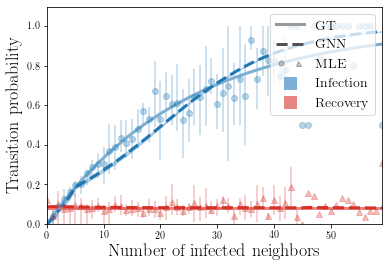

In [7]:
import sys

from dynalearn.experiments import LTPMetrics
from dynalearn.util.display import *
transitions = [(0, 1), (1, 0)]
colors = {
    "true": [color_pale["blue"], color_pale["red"]],
    "gnn": [color_dark["blue"], color_dark["red"]],
    "mle": [color_dark["blue"], color_dark["red"]],
}
linestyles = {
    "true": ["-", "-"],
    "gnn": ["--", "--"],
    "mle": ["None", "None"],
}
markers = {
    "true": ["None", "None"],
    "gnn": ["None", "None"],
    "mle": ["o", "^"],
}

def plot_ltp(experiment, ax):
    summary = experiment.metrics["TrueLTPMetrics"].data["summaries"]
    true_ltp = experiment.metrics["TrueLTPMetrics"].data["ltp"]
    gnn_ltp = experiment.metrics["GNNLTPMetrics"].data["ltp"]
    mle_ltp = experiment.metrics["MLELTPMetrics"].data["ltp"]
    agg = lambda ltp, in_s, out_s: LTPMetrics.aggregate(
            ltp, summary, 
            in_state=in_s, 
            out_state=out_s,
            axis=1, 
            reduce="mean", 
            err_reduce="percentile"
        )
    x_min, x_max = -np.inf, np.inf
    for i, (in_s, out_s) in enumerate(transitions):
        x, y, yl, yh = agg(true_ltp, in_s, out_s)
        ax.plot(
            x, y, color=colors["true"][i], linestyle=linestyles["true"][i],marker=markers["true"][i],linewidth=3
        )
        ax.fill_between(x, yl, yh, color=colors["true"][i], alpha=0.3)
        
        x, y, yl, yh = agg(gnn_ltp, in_s, out_s)
        ax.plot(
            x, y, color=colors["gnn"][i], linestyle=linestyles["gnn"][i],marker=markers["gnn"][i],linewidth=3
        )
        ax.fill_between(x, yl, yh, color=colors["gnn"][i], alpha=0.3)
        
        x, y, yl, yh = agg(mle_ltp, in_s, out_s)
        yerr = np.concatenate([np.expand_dims(y-yl,0), np.expand_dims(yh-y,0)], axis=0)
        ax.errorbar(
            x, 
            y, 
            yerr=yerr,
            color=colors["mle"][i], 
            linestyle=linestyles["mle"][i], 
            marker=markers["mle"][i], 
            alpha=0.3
        )
#         ax.plot(
#             x, y, color=colors["mle"][i], linestyle=linestyles["mle"][i], marker=markers["mle"][i], alpha=0.5
#         )
#         ax.fill_between(x, yl, yh, color=colors["mle"][i], alpha=0.3)
        
        if x.min() > x_min:
            x_min = x.min()
        if x.max() < x_max:
            x_max = x.max()
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([0, 1.1])
    return ax

fig, ax = plt.subplots(1, 1)

plot_ltp(exp, ax)
ax.set_xlabel("Number of infected neighbors", fontsize=18)
ax.set_ylabel("Transition probability", fontsize=18)
handles = []

handles.append(Line2D([-1], [-1], linestyle="-", marker="None", linewidth=3,
                     color=color_pale["grey"], 
                     label=r"True")
             )
handles.append(Line2D([-1], [-1], linestyle="--", marker="None", linewidth=3,
                     color=color_dark["grey"], 
                     label=r"GNN")
             )
handles.append((Line2D([-1], [-1], linestyle="None", marker="o", markersize=5, markeredgewidth=1,
                      markeredgecolor='k', color=color_dark["grey"], alpha=0.3),
                Line2D([-1], [-1], linestyle="None", marker="^", markersize=5, markeredgewidth=1,
                      markeredgecolor='k', color=color_dark["grey"], alpha=0.3))
             )
handles.append(Line2D([-1], [-1], linestyle="None", marker="s", markersize=12,
                     color=color_pale["blue"])
             )
handles.append(Line2D([-1], [-1], linestyle="None", marker="s", markersize=12,
                     color=color_pale["red"])
             )
ax.legend(handles=handles, 
             labels=[r"GT", r"GNN", r"MLE", "Infection", "Recovery"],
             handler_map={tuple: HandlerTuple(ndivide=None)},
             loc="upper right", fancybox=True, fontsize=14, framealpha=0.75, ncol=1
)
plt.show()